In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

In [2]:
DATA_DIR = '/home/dmitry/projects/dfdc/data/dfdc-videos'

In [10]:
!ls $DATA_DIR

dfdc_train_part_0  dfdc_train_part_1


In [56]:
def read_labels(base_path):
    if not os.path.isdir(base_path):
        raise ValueError('Invalid data dir')
    chunk_dirs = os.listdir(base_path)
    labels = []
    for dir_name in chunk_dirs:
        path = os.path.join(base_path, dir_name, 'metadata.json')
        df = pd.read_json(path).T
        df['dir'] = dir_name
        df['label'] = (df['label'] == 'FAKE').astype(np.uint8)
        labels.append(df)
    return pd.concat(labels)

In [58]:
# https://www.kaggle.com/humananalog/deepfakes-inference-demo

class VideoReader:
    """Helper class for reading one or more frames from a video file."""

    def __init__(self, verbose=True, insets=(0, 0)):
        """Creates a new VideoReader.

        Arguments:
            verbose: whether to print warnings and error messages
            insets: amount to inset the image by, as a percentage of 
                (width, height). This lets you "zoom in" to an image 
                to remove unimportant content around the borders. 
                Useful for face detection, which may not work if the 
                faces are too small.
        """
        self.verbose = verbose
        self.insets = insets

    def read_frames(self, path, num_frames, jitter=0, seed=None):
        """Reads frames that are always evenly spaced throughout the video.

        Arguments:
            path: the video file
            num_frames: how many frames to read, -1 means the entire video
                (warning: this will take up a lot of memory!)
            jitter: if not 0, adds small random offsets to the frame indices;
                this is useful so we don't always land on even or odd frames
            seed: random seed for jittering; if you set this to a fixed value,
                you probably want to set it only on the first video 
        """
        assert num_frames > 0

        capture = cv2.VideoCapture(path)
        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_count <= 0: return None

        frame_idxs = np.linspace(0, frame_count - 1, num_frames, endpoint=True, dtype=np.int)
        if jitter > 0:
            np.random.seed(seed)
            jitter_offsets = np.random.randint(-jitter, jitter, len(frame_idxs))
            frame_idxs = np.clip(frame_idxs + jitter_offsets, 0, frame_count - 1)

        result = self._read_frames_at_indices(path, capture, frame_idxs)
        capture.release()
        return result

    def read_random_frames(self, path, num_frames, seed=None):
        """Picks the frame indices at random.
        
        Arguments:
            path: the video file
            num_frames: how many frames to read, -1 means the entire video
                (warning: this will take up a lot of memory!)
        """
        assert num_frames > 0
        np.random.seed(seed)

        capture = cv2.VideoCapture(path)
        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_count <= 0: return None

        frame_idxs = sorted(np.random.choice(np.arange(0, frame_count), num_frames))
        result = self._read_frames_at_indices(path, capture, frame_idxs)

        capture.release()
        return result

    def read_frames_at_indices(self, path, frame_idxs):
        """Reads frames from a video and puts them into a NumPy array.

        Arguments:
            path: the video file
            frame_idxs: a list of frame indices. Important: should be
                sorted from low-to-high! If an index appears multiple
                times, the frame is still read only once.

        Returns:
            - a NumPy array of shape (num_frames, height, width, 3)
            - a list of the frame indices that were read

        Reading stops if loading a frame fails, in which case the first
        dimension returned may actually be less than num_frames.

        Returns None if an exception is thrown for any reason, or if no
        frames were read.
        """
        assert len(frame_idxs) > 0
        capture = cv2.VideoCapture(path)
        result = self._read_frames_at_indices(path, capture, frame_idxs)
        capture.release()
        return result

    def _read_frames_at_indices(self, path, capture, frame_idxs):
        try:
            frames = []
            idxs_read = []
            for frame_idx in range(frame_idxs[0], frame_idxs[-1] + 1):
                # Get the next frame, but don't decode if we're not using it.
                ret = capture.grab()
                if not ret:
                    if self.verbose:
                        print("Error grabbing frame %d from movie %s" % (frame_idx, path))
                    break

                # Need to look at this frame?
                current = len(idxs_read)
                if frame_idx == frame_idxs[current]:
                    ret, frame = capture.retrieve()
                    if not ret or frame is None:
                        if self.verbose:
                            print("Error retrieving frame %d from movie %s" % (frame_idx, path))
                        break

                    frame = self._postprocess_frame(frame)
                    frames.append(frame)
                    idxs_read.append(frame_idx)

            if len(frames) > 0:
                return np.stack(frames), idxs_read
            if self.verbose:
                print("No frames read from movie %s" % path)
            return None
        except:
            if self.verbose:
                print("Exception while reading movie %s" % path)
            return None    

    def read_middle_frame(self, path):
        """Reads the frame from the middle of the video."""
        capture = cv2.VideoCapture(path)
        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        result = self._read_frame_at_index(path, capture, frame_count // 2)
        capture.release()
        return result

    def read_frame_at_index(self, path, frame_idx):
        """Reads a single frame from a video.
        
        If you just want to read a single frame from the video, this is more
        efficient than scanning through the video to find the frame. However,
        for reading multiple frames it's not efficient.
        
        My guess is that a "streaming" approach is more efficient than a 
        "random access" approach because, unless you happen to grab a keyframe, 
        the decoder still needs to read all the previous frames in order to 
        reconstruct the one you're asking for.

        Returns a NumPy array of shape (1, H, W, 3) and the index of the frame,
        or None if reading failed.
        """
        capture = cv2.VideoCapture(path)
        result = self._read_frame_at_index(path, capture, frame_idx)
        capture.release()
        return result

    def _read_frame_at_index(self, path, capture, frame_idx):
        capture.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = capture.read()    
        if not ret or frame is None:
            if self.verbose:
                print("Error retrieving frame %d from movie %s" % (frame_idx, path))
            return None
        else:
            frame = self._postprocess_frame(frame)
            return np.expand_dims(frame, axis=0), [frame_idx]
    
    def _postprocess_frame(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if self.insets[0] > 0:
            W = frame.shape[1]
            p = int(W * self.insets[0])
            frame = frame[:, p:-p, :]

        if self.insets[1] > 0:
            H = frame.shape[1]
            q = int(H * self.insets[1])
            frame = frame[q:-q, :, :]

        return frame

In [70]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [57]:
df = read_labels(DATA_DIR)
print(df.shape)
df.head()

(3033, 4)


,label,split,original,dir
owxbbpjpch.mp4,1,train,wynotylpnm.mp4,dfdc_train_part_0
vpmyeepbep.mp4,0,train,NaN,dfdc_train_part_0
fzvpbrzssi.mp4,0,train,NaN,dfdc_train_part_0
htorvhbcae.mp4,1,train,wclvkepakb.mp4,dfdc_train_part_0
fckxaqjbxk.mp4,1,train,vpmyeepbep.mp4,dfdc_train_part_0


In [59]:
reader = VideoReader()

In [68]:
i = 0
row = df.iloc[i]
file_path = os.path.join(DATA_DIR, row.dir, row.name)
sample, frames = reader.read_frames(file_path, 10)

In [69]:
sample.shape

(10, 1920, 1080, 3)

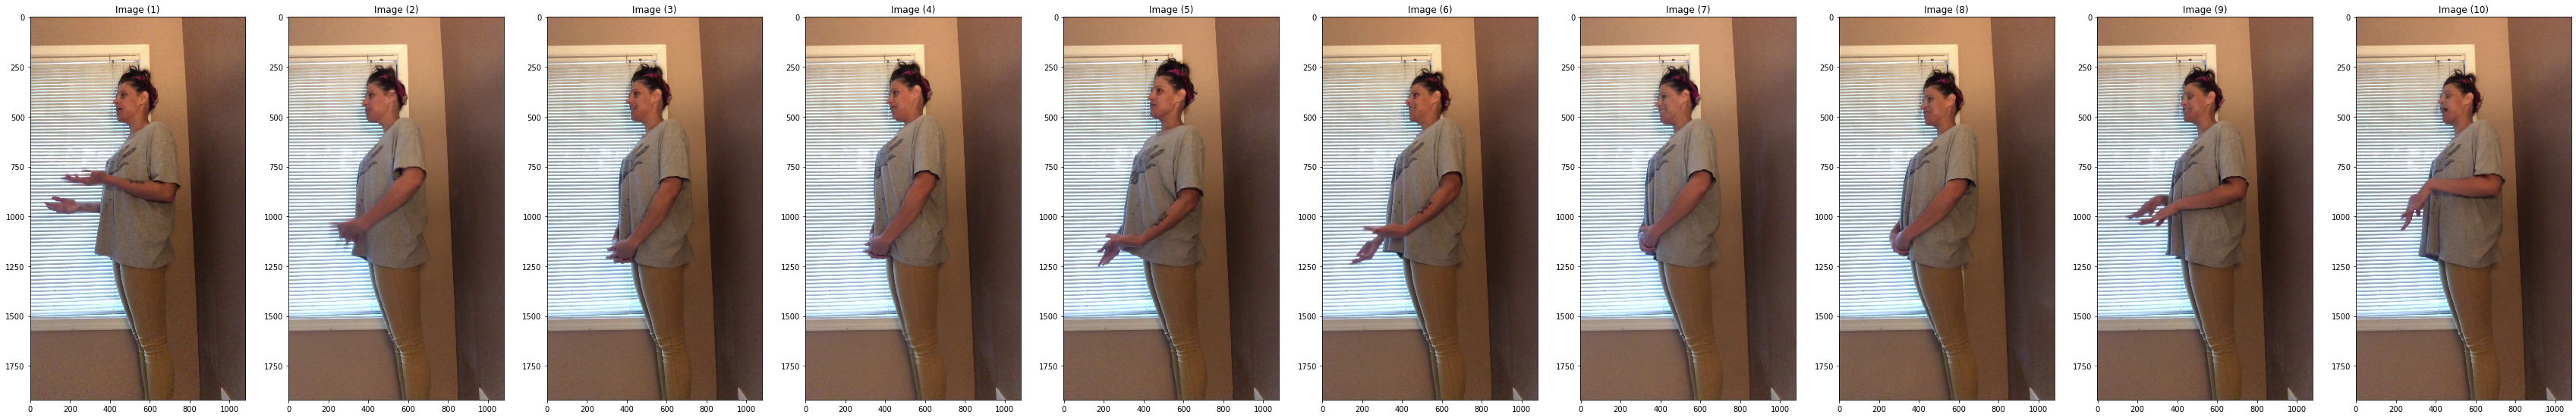

In [71]:
show_images(sample)